In [5]:
##### %matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"#不加这行 在跑d2l代码时内核可能崩溃
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display

def get_dataloader_workers():
    """使用4个进程来读取的数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize)) # 如果有Resize参数传进来，就进行resize操作
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="./data",train=True,transform=trans,download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="./data",train=False,transform=trans,download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
           data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()))


batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size) # 返回训练集、测试集的迭代器
print(train_iter)
num_inputs = 784 # 28 * 28 图片的长和宽都是28，把它拉成一条向量
num_outputs = 10 #数据集有10个类
w = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

def softmax(X):
    X_exp = torch.exp(X) # 每个都进行指数运算
    partition = X_exp.sum(1,keepdim=True)
    return X_exp / partition # 这里应用了广播机制

# 实现softmax回归模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1,w.shape[0])),w)+b) # -1为默认的批量大小，表示有多少个图片，每个图片用一维的784列个元素表示      

AttributeError: 'DataLoader' object has no attribute 'shape'

In [2]:
def cross_entropy(y_hat, y):
    print(len(y_hat))
    print(y_hat.shape)
    print(y.shape)
    print(y)
    print('-------')
    return -torch.log(y_hat[range(len(y_hat)),y]) # y_hat[range(len(y_hat)),y]为把y的标号列表对应的值拿出来。传入的y要是最大概率的标号
#创建一个数据`y_hat`，其中包含2个样本在3个类别的预测概率，使用`y`作为`y_hat`中概率的索引
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5],[666,666,666],[666,666,666],[666,666,666]])
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

上面这里总结出一个语法，一个tensor的`[]`运算符内用逗号隔开的各部分会先后进行索引运算

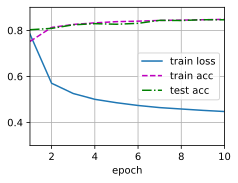

In [3]:
def accuracy(y_hat,y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # y_hat.shape[1]>1表示不止一个类别，每个类别有各自的概率
        y_hat = y_hat.argmax(axis=1) # y_hat.argmax(axis=1)为求行最大值的索引
    cmp = y_hat.type(y.dtype) == y # 先判断逻辑运算符==，再赋值给cmp，cmp为布尔类型的数据
    return float(cmp.type(y.dtype).sum()) # 获得y.dtype的类型作为传入参数，将cmp的类型转为y的类型（int型），然后再求和

# 可以评估在任意模型net的准确率
def evaluate_accuracy(net,data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net,torch.nn.Module): # 如果net模型是torch.nn.Module实现的神经网络的话，将它变成评估模式     
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数，metric为累加器的实例化对象，里面存了两个数
    for X, y in data_iter:
        metric.add(accuracy(net(X),y),y.numel()) # net(X)将X输入模型，获得预测值。y.numel()为样本总数
    return metric[0] / metric[1] # 分类正确的样本数 / 总样本数

# Accumulator实例中创建了2个变量，用于分别存储正确预测的数量和预测的总数量
class Accumulator:
    """在n个变量上累加"""
    def __init__(self,n):
        self.data = [0,0] * n
        
    def add(self, *args):
        self.data = [a+float(b) for a,b in zip(self.data,args)] # zip函数把两个列表第一个位置元素打包、第二个位置元素打包....
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self,idx):
        return self.data[idx]

# 训练函数
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train() # 开启训练模式
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y) # 计算损失
        if isinstance(updater, torch.optim.Optimizer): # 如果updater是pytorch的优化器的话
            updater.zero_grad()
            l.mean().backward()  # 这里对loss取了平均值出来
            updater.step()
            metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel()) # 总的训练损失、样本正确数、样本总数   
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()),accuracy(y_hat,y),y.numel()) 
    return metric[0] / metric[2], metric[1] / metric[2] # 所有loss累加除以样本总数，总的正确个数除以样本总数  


    
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear',yscale='linear',
                fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                figsize=(3.5,2.5)): 
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)         
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# 总训练函数        
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],
                       legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):  # 变量num_epochs遍数据
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater) # 返回两个值，一个总损失、一个总正确率
        test_acc = evaluate_accuracy(net, test_iter) # 测试数据集上评估精度，仅返回一个值，总正确率
        animator.add(epoch+1,train_metrics+(test_acc,)) # train_metrics+(test_acc,) 仅将两个值的正确率相加，
    train_loss, train_acc = train_metrics
    
# 小批量随即梯度下降来优化模型的损失函数
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad #如果squared_loss函数里没有除以batch_size 就要在这里做
            param.grad.zero_()#清除梯度 不清除会导致梯度累加 结果不正确
lr = 0.1
def updater(batch_size):
    return d2l.sgd([w,b],lr,batch_size)

num_epochs = 10
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

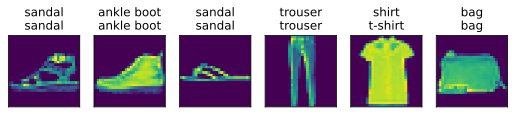

In [4]:
def predict_ch3(net,test_iter,n=6):
    for X, y in test_iter:
        break # 仅拿出一批六个数据
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])
    
predict_ch3(net, test_iter)